In [13]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import itertools
import os
from root_numpy import root2array, root2rec, tree2array, array2root
%matplotlib inline

In [23]:
#f_tll = TFile("ana.root","READ")

f = ROOT.TFile('ana_hitcalib_69_test.root')
#f = ROOT.TFile('calib_ana150.root')
t = f.Get('tree')
df = pd.DataFrame(tree2array(t)) #,branches=['_pi0_energy','_clus_nhits_v','_clus_vtxdist_v','_clus_plane_v']))

In [24]:
#df.head()
df[(df['_pl'] == 2)].head()

,_pl,_wire,_chan,_reco_area,_reco_ampl,_q,_tick,_event,_clus
332,2,3130,7930,73.799606,7.059659,15785.388126,4289,0,4
333,2,3131,7931,61.555649,5.492179,12143.576979,4289,0,4
334,2,3165,7965,97.612946,6.885799,19325.209383,4266,0,4
335,2,3166,7966,108.185364,7.263369,21246.316602,4268,0,4
336,2,3188,7988,97.560486,8.559093,19538.756447,4348,0,4


In [25]:
true_q = [ df['_q'][i] for i in xrange(df['_q'].shape[0]) ]
reco_q = [ df['_reco_area'][i] for i in xrange(df['_reco_area'].shape[0]) ]

gain_v = [ true_q[i] / reco_q[i] for i in xrange(len(true_q)) if df['_pl'][i]==2]
chan_v = [df['_chan'][i] for i in xrange(df['_chan'].shape[0]) if df['_pl'][i]==2]

tick_v = [df['_tick'][i] for i in xrange(df['_tick'].shape[0]) if df['_pl'][i]==2]
wire_v = [df['_wire'][i] for i in xrange(df['_tick'].shape[0]) if df['_pl'][i]==2]

print len(reco_q), len(true_q)

#print reco_q

599 599


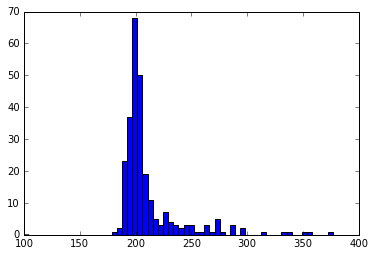

In [26]:
temp = [ int(gain_v[i]) for i in xrange(len(gain_v))]
#print temp
_,_ ,_ = plt.hist(temp,bins=65,range=[100,400])


In [27]:
#http://statsmodels.sourceforge.net/
# Perform an ordinary least squares fit + evaluate influence of points to exclude outliers
import statsmodels.api as sm

UR_fit = sm.add_constant(wire_v)
model = sm.OLS(gain_v,UR_fit).fit()

influ_v = model.get_influence()
influ_s = influ_v.summary_frame()['student_resid']
outliers = influ_s.ix[abs(influ_s) > .75] # 0.1 Chosen visually

gain_out = [ gain_v[i] for i in xrange(len(gain_v)) if i in outliers ]
wire_out = [ wire_v[i] for i in xrange(len(gain_v)) if i in outliers ]
tick_out = [ tick_v[i] for i in xrange(len(gain_v)) if i in outliers ]

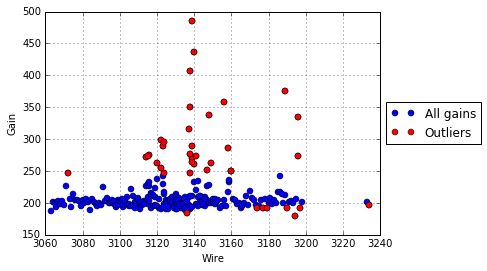

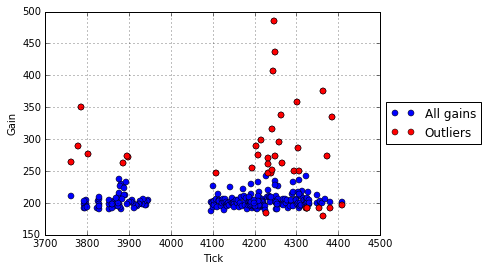

In [28]:

plt.figure()
plt.plot(wire_v,gain_v,'bo',label='All gains')
plt.plot(wire_out,gain_out,'ro',label='Outliers')
plt.xlabel("Wire")
plt.ylabel("Gain")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.figure()
plt.plot(tick_v,gain_v,'bo',label='All gains')
plt.plot(tick_out,gain_out,'ro',label='Outliers')
plt.xlabel("Tick")
plt.ylabel("Gain")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
x = np.arange(min(wire_v),max(wire_v)+1,1)
y = np.arange(min(tick_v),max(tick_v)+1,6) 

display = np.zeros([len(y),len(x)])

print display.shape
new_wire_v = [ wire_v[i] - min(wire_v) for i in xrange(len(wire_v))]
new_tick_v = [ (tick_v[i] - min(tick_v))/6 for i in xrange(len(tick_v))]

new_wire_out = [ wire_out[i] - min(wire_v) for i in xrange(len(wire_out))]
new_tick_out = [ (tick_out[i] - min(tick_v))/6 for i in xrange(len(tick_out))]

for i in xrange(len(new_wire_v)):
    
    t = new_tick_v[i]
    w = new_wire_v[i]
    #if gain_v[i] < 1000:
    display[t][w] = gain_v[i]

(108, 172)


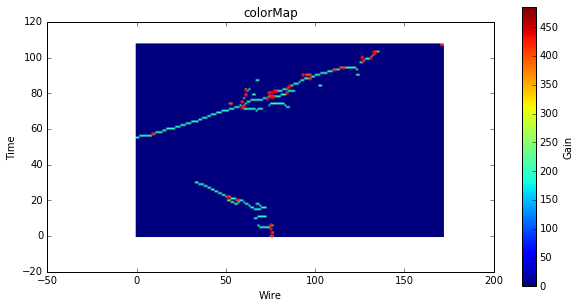

In [30]:
plt.figure(figsize=(10, 5))
plt.title('colorMap')
plt.imshow(display)#,cmap='hot') #gist_heat')
plt.plot(new_wire_out,new_tick_out,'r.',alpha=0.7)#,label='showers')
plt.gca().invert_yaxis()
plt.xlabel("Wire")
plt.ylabel("Time")

plt.colorbar(orientation='vertical',label='Gain')#,cmap='Ancient')#,boundaries=[100,1000],values=[100,1000])
plt.show()


0.035799751374 91.5824416428


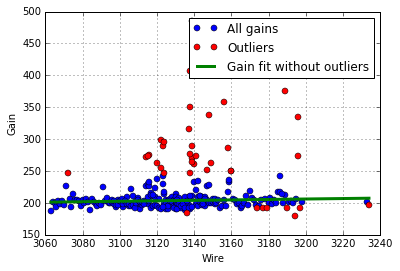

In [236]:
gain_plot = []
wire_plot = []
for i in xrange(len(gain_v)):
    if i not in outliers:
        gain_plot.append(gain_v[i])
        wire_plot.append(wire_v[i])
    
    #plt.plot(float(unemp_rate[i]),crime_rate[i],'kx')
    
# This fit neglects points I've visually decided are outliers

m,b = np.polyfit(wire_plot, gain_plot,1)
print m, b

fitx = np.linspace(min(wire_v),max(wire_v),100)

plt.figure()
plt.plot(wire_plot,gain_plot,'bo',label='All gains')
plt.plot(wire_out,gain_out,'ro',label='Outliers')
plt.plot(fitx,m*fitx+b,'g-',lw=3,label='Gain fit without outliers')
plt.xlabel("Wire")
plt.ylabel("Gain")
plt.grid(True)
plt.legend()

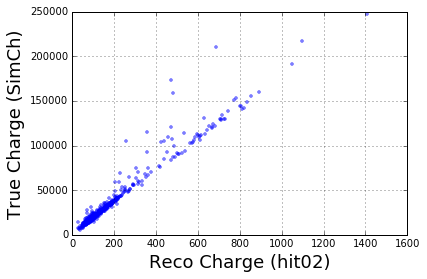

In [135]:
### plt.figure()
plt.plot(reco_q,true_q,'b.',alpha=0.5)#,label='showers')
plt.grid(True)
plt.xlabel("Reco Charge (hit02)",fontsize=18)
plt.ylabel("True Charge (SimCh)",fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [42]:
clus_v = [df['_clus'][i] for i in xrange(df['_tick'].shape[0]) if df['_pl'][i]==2]
print np.unique(clus_v)
u_clus = np.unique(clus_v)

tick_v_0 = [tick_v[i] for i in xrange(len(tick_v)) if clus_v[i]==u_clus[0]]
wire_v_0 = [wire_v[i] for i in xrange(len(tick_v)) if clus_v[i]==u_clus[0]]
tick_v_1 = [tick_v[i] for i in xrange(len(tick_v)) if clus_v[i]==u_clus[1]]
wire_v_1 = [wire_v[i] for i in xrange(len(tick_v)) if clus_v[i]==u_clus[1]]


gain_v_0 = [gain_v[i] for i in xrange(len(gain_v)) if clus_v[i]==u_clus[0]]
gain_v_1 = [gain_v[i] for i in xrange(len(gain_v)) if clus_v[i]==u_clus[1]]

print len(gain_v_0)

[4 5]
197


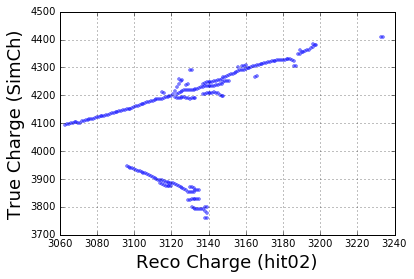

In [43]:
plt.figure()
plt.plot(wire_v,tick_v,'b.',alpha=0.5)#,label='showers')
plt.grid(True)
plt.xlabel("Reco Charge (hit02)",fontsize=18)
plt.ylabel("True Charge (SimCh)",fontsize=18)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


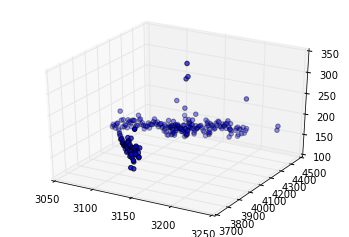

In [48]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wire_v, tick_v, gain_v,c='b')
#ax.zlim(0,2000)
#ax.scatter(wire_v_1, tick_v_1, gain_v_1,c='r')#,m='*') #, zdir='z', s=20, c=None, depthshade=True, *args, **kwargs)
#ax.scatter(wire_v_0, tick_v_0, gain_v_0,c='b')


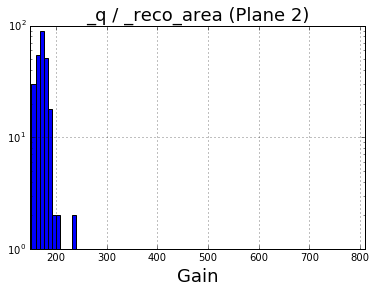

In [45]:
plt.figure()
plt.hist(gain_v,100,range=[0,800])#,'b.',alpha=0.5)#,label='showers')
plt.grid(True)
plt.title('_q / _reco_area (Plane 2)',fontsize=18 )
plt.xlabel("Gain",fontsize=18)
plt.xlim(150,810)
plt.yscale('log')
#plt.ylabel("True Charge (SimCh)",fontsize=18)
#plt.ylim(0,1000)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(0, 2000)

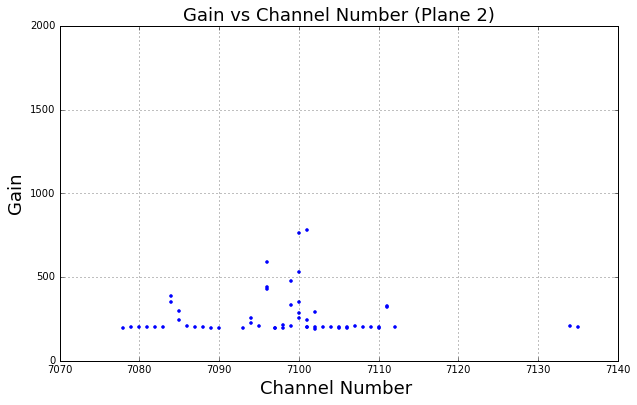

In [145]:
plt.figure(figsize=(10,6))
plt.plot(chan_v,gain_v,'b.') #,100,range=[0,800])#,'b.',alpha=0.5)#,label='showers')
plt.grid(True)
plt.title('Gain vs Channel Number (Plane 2)',fontsize=18 )
plt.xlabel("Channel Number ",fontsize=18)
#plt.xlim(7860,8040)
#plt.xlim(6500,7000)
#plt.yscale('log')
plt.ylabel("Gain",fontsize=18)
plt.ylim(0,2000)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(0, 2000)

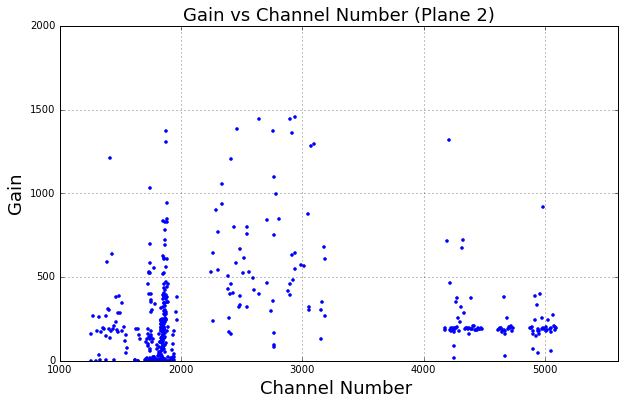

In [196]:
plt.figure(figsize=(10,6))
plt.plot(tick_v,gain_v,'b.') #,100,range=[0,800])#,'b.',alpha=0.5)#,label='showers')
plt.grid(True)
plt.title('Gain vs Channel Number (Plane 2)',fontsize=18 )
plt.xlabel("Channel Number ",fontsize=18)
plt.xlim(1000,5600)
#plt.yscale('log')
plt.ylabel("Gain",fontsize=18)
plt.ylim(0,2000)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))